# <center> Product Funnel & Growth Diagnostics</center>
### <center> Conversion Analysis, Experiment Design & Revenue Impact  </center>
---

**Period:** Q1 2015 (Jan - Apr)  
**Analyst:** Taroon Ganesh  

## Business Problem  
Our conversion rate has plateaued at **0.5%**. Leadership wants to understand:

1. **Where are we losing customers in the funnel?**  
2. **Why is mobile performing differently than desktop?**  
3. **What’s the revenue impact of fixing bottlenecks?**  
4. **What should we prioritize first (with testable recommendations)?**

## Expected Outcome  
- Identify the **top 3 conversion barriers**
- Quantify **revenue opportunity** from fixing bottlenecks
- Propose **A/B tests** with success metrics and projected ROI

### 1) Data Inputs

We work with 5 tables loaded into Pandas DataFrames:

- `home_page`, `search_page`, `payment_page`, `payment_confirmation`: page-level events containing `user_id`
- `user`: user attributes (`date`, `device`, `sex`)

Each page table represents users who reached that funnel step at least once.  
The analysis converts these into a **user-level funnel dataset** (one row per user) to avoid double counting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import warnings
warnings.filterwarnings('ignore')


# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

### 2) Business Assumptions & Key Metrics

To translate funnel improvements into business impact, we use two assumptions:

- **Average Booking Value (AOV):** \$250  
- **Monthly Traffic:** ~22,600 home-page visitors (used for scenario sizing)

> These are modeling assumptions. In production, AOV and traffic would be sourced from finance and analytics tracking.

In [3]:
# Business assumptions
AVERAGE_BOOKING_VALUE = 250  # Average transaction value in USD
MONTHLY_TRAFFIC = 22600  # Average monthly home page visitors

### 3) Data Quality Checks & Funnel Construction

This section:
- Loads the five tables and runs **basic data quality checks** (nulls, duplicates).
- Builds a **user-level funnel dataset** with binary flags:
  - `home`, `search`, `payment`, `confirmation`
- Runs **validation checks** for illogical flows (e.g., confirmation without payment).

**Why it matters:** Funnel analysis must be computed on **unique users per stage** to avoid inflated conversion rates.

In [5]:
def load_and_validate_data():
    """Load data with quality checks"""
    
    datasets = {
        'home': pd.read_csv("home_page_table.csv"),
        'search': pd.read_csv("search_page_table.csv"),
        'payment': pd.read_csv("payment_page_table.csv"),
        'confirmation': pd.read_csv("payment_confirmation_table.csv"),
        'user': pd.read_csv("user_table.csv")
    }
    
    # Data quality report
    print("\n" + "="*70)
    print("DATA QUALITY REPORT")
    print("="*70)
    
    for name, df in datasets.items():
        print(f"{name:15s}: {len(df):,} records, {df.isnull().sum().sum()} nulls")
    
    # Check for duplicates
    user_dups = datasets['user']['user_id'].duplicated().sum()
    print(f"\nDuplicate users: {user_dups}")
    
    return datasets

In [7]:
def prepare_funnel_data(datasets):
    """Transform to user-level with validation"""
    
    # Combine all events
    events = []
    stage_mapping = {
        'home': 'home',
        'search': 'search', 
        'payment': 'payment',
        'confirmation': 'confirmation'
    }
    
    for key, stage in stage_mapping.items():
        df = datasets[key][['user_id']].copy()
        df['stage'] = stage
        events.append(df)
    
    events_df = pd.concat(events, ignore_index=True).drop_duplicates()
    
    # Pivot to user-level
    funnel = events_df.pivot_table(
        index='user_id',
        columns='stage',
        aggfunc='size',
        fill_value=0
    )
    
    # Ensure all stages exist
    for stage in ['home', 'search', 'payment', 'confirmation']:
        if stage not in funnel.columns:
            funnel[stage] = 0
    
    funnel = (funnel > 0).astype(int)
    
    # Add user attributes
    user_df = datasets['user'].copy()
    user_df['date'] = pd.to_datetime(user_df['date'])
    user_df['cohort_month'] = user_df['date'].dt.to_period('M').astype(str)
    user_df['week'] = user_df['date'].dt.isocalendar().week
    
    df = funnel.reset_index().merge(user_df, on='user_id', how='left')
    
    # Data validation checks
    print("\n" + "="*70)
    print("DATA VALIDATION")
    print("="*70)
    
    # Check illogical journeys
    illogical_payment = ((df['payment'] == 1) & (df['search'] == 0)).sum()
    illogical_confirm = ((df['confirmation'] == 1) & (df['payment'] == 0)).sum()
    
    print(f"Users with payment but no search: {illogical_payment}")
    print(f"Users with confirmation but no payment: {illogical_confirm}")
    print(f"Total users: {len(df):,}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Devices: {df['device'].value_counts().to_dict()}")
    
    return df

## 4) Core Funnel Metrics

We compute:
- **Stage counts**: users reaching each step
- **Stage-to-stage conversion rates**
  - Home → Search  
  - Search → Payment (Checkout Start)  
  - Payment → Confirmation (Checkout Completion)  
- **Drop-offs** at each transition

These metrics are calculated overall and can also be segmented by dimensions like **device**, **sex**, and **cohort**.

In [9]:
def calculate_funnel_metrics(df, group_by=None):
    """Calculate all conversion metrics"""
    
    stages = ['home', 'search', 'payment', 'confirmation']
    
    if group_by:
        counts = df.groupby(group_by)[stages].sum()
    else:
        counts = df[stages].sum().to_frame().T
        counts.index = ['Overall']
    
    # Calculate conversion rates
    metrics = counts.copy()
    metrics['home_to_search'] = metrics['search'] / metrics['home']
    metrics['search_to_payment'] = metrics['payment'] / metrics['search']
    metrics['payment_to_confirm'] = metrics['confirmation'] / metrics['payment']
    metrics['home_to_confirm'] = metrics['confirmation'] / metrics['home']
    
    # Calculate drop-offs
    metrics['drop_home_search'] = metrics['home'] - metrics['search']
    metrics['drop_search_payment'] = metrics['search'] - metrics['payment']
    metrics['drop_payment_confirm'] = metrics['payment'] - metrics['confirmation']
    
    return metrics

### 5) Revenue Impact & Opportunity Sizing (Scenario-Based)

To prioritize what to fix first, we translate conversion improvements into **estimated revenue lift** using:

**Incremental revenue ≈ (Incremental conversions) × (AOV)**

We model improvement scenarios such as:
- Improving **checkout completion** (Payment → Confirmation)
- Closing the **Desktop vs Mobile** performance gap

> Revenue impact is scenario-based and depends on assumptions (AOV, traffic). The main goal is to support prioritization.

In [11]:
def calculate_revenue_impact(df):
    """Calculate revenue and opportunity metrics"""
    
    current_conversions = df['confirmation'].sum()
    potential_users = df['home'].sum()
    
    # Current revenue
    current_revenue = current_conversions * AVERAGE_BOOKING_VALUE
    
    # Scenarios
    scenarios = {
        'current': {
            'rate': df['confirmation'].sum() / df['home'].sum(),
            'conversions': current_conversions
        },
        'fix_payment_step': {
            'rate': (df['payment'].sum() * 0.15) / df['home'].sum(),  # Improve from 7.5% to 15%
            'conversions': df['payment'].sum() * 0.15
        },
        'match_mobile_performance': {
            'mobile_rate': df[df['device']=='Mobile']['confirmation'].sum() / df[df['device']=='Mobile']['home'].sum(),
            'conversions': potential_users * (df[df['device']=='Mobile']['confirmation'].sum() / df[df['device']=='Mobile']['home'].sum())
        }
    }
    
    results = {}
    for scenario, data in scenarios.items():
        if 'conversions' in data:
            revenue = data['conversions'] * AVERAGE_BOOKING_VALUE
            results[scenario] = {
                'conversions': data['conversions'],
                'revenue': revenue,
                'lift': revenue - current_revenue
            }
    
    return results

### 6) Deep Dives: Segments, Cohorts, and Diagnostics

After baseline funnel metrics, we dig deeper to understand **why** conversion differs:

#### a) Behavioral Segmentation
Classify users into practical product segments:
- **Bounced** (home only)
- **Browsers** (searched but didn’t start checkout)
- **Checkout Starters** (reached payment page but didn’t convert)
- **Converters** (reached confirmation)

#### b) Cohort Analysis
Analyze conversion performance by **signup month** to spot time-based shifts (seasonality, acquisition quality, product changes).

#### c) Device Deep Dive + Statistical Testing
Validate whether Desktop vs Mobile differences are statistically significant using **two-proportion z-tests**.

#### d) Anomaly Flags
Surface unusual weekly patterns or outlier behavior that may indicate tracking issues or real product incidents.

In [13]:
def analyze_user_segments(df):
    """Segment users by behavior patterns"""
    
    # Define segments
    df['segment'] = 'Bounced'
    df.loc[df['search'] == 1, 'segment'] = 'Browsers'
    df.loc[df['payment'] == 1, 'segment'] = 'Cart Abandoners'
    df.loc[df['confirmation'] == 1, 'segment'] = 'Converters'
    
    segment_summary = df.groupby('segment').agg({
        'user_id': 'count',
        'device': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
    }).rename(columns={'user_id': 'count'})
    
    segment_summary['percentage'] = (segment_summary['count'] / len(df) * 100).round(2)
    
    return df, segment_summary

def analyze_cohort_behavior(df):
    """Analyze performance by signup cohort"""
    
    cohort_metrics = df.groupby('cohort_month').agg({
        'home': 'sum',
        'confirmation': 'sum',
        'user_id': 'count'
    })
    
    cohort_metrics['conversion_rate'] = cohort_metrics['confirmation'] / cohort_metrics['home']
    cohort_metrics['revenue'] = cohort_metrics['confirmation'] * AVERAGE_BOOKING_VALUE
    
    return cohort_metrics

def device_deep_dive(df):
    """Detailed device comparison with statistical tests"""
    
    device_metrics = calculate_funnel_metrics(df, group_by='device')
    
    # Statistical test: Mobile vs Desktop at each stage
    mobile_data = df[df['device'] == 'Mobile']
    desktop_data = df[df['device'] == 'Desktop']
    
    tests = {}
    stages = [
        ('home', 'search', 'Search Rate'),
        ('search', 'payment', 'Payment Rate'),
        ('payment', 'confirmation', 'Completion Rate')
    ]
    
    for stage_from, stage_to, name in stages:
        mobile_success = mobile_data[stage_to].sum()
        mobile_total = mobile_data[stage_from].sum()
        desktop_success = desktop_data[stage_to].sum()
        desktop_total = desktop_data[stage_from].sum()
        
        if desktop_total > 0 and mobile_total > 0:
            z_stat, p_val = proportions_ztest(
                [desktop_success, mobile_success],
                [desktop_total, mobile_total]
            )
            
            tests[name] = {
                'mobile_rate': mobile_success / mobile_total,
                'desktop_rate': desktop_success / desktop_total,
                'p_value': p_val,
                'significant': p_val < 0.05
            }
    
    return device_metrics, tests

def identify_anomalies(df):
    """Find unusual patterns that need investigation"""
    
    anomalies = []
    
    # Check for weekly patterns
    weekly = df.groupby('week').agg({
        'confirmation': 'sum',
        'home': 'sum'
    })
    weekly['conv_rate'] = weekly['confirmation'] / weekly['home']
    
    mean_rate = weekly['conv_rate'].mean()
    std_rate = weekly['conv_rate'].std()
    
    outlier_weeks = weekly[
        (weekly['conv_rate'] < mean_rate - 2*std_rate) | 
        (weekly['conv_rate'] > mean_rate + 2*std_rate)
    ]
    
    if len(outlier_weeks) > 0:
        anomalies.append(f" !!  {len(outlier_weeks)} weeks with unusual conversion rates")
    
    # Check gender imbalance
    gender_conv = df.groupby('sex')['confirmation'].sum() / df.groupby('sex')['home'].sum()
    if gender_conv.max() / gender_conv.min() > 1.5:
        anomalies.append(f" !!  Significant gender conversion gap: {gender_conv.to_dict()}")
    
    return anomalies

### 7) Visualizations for Stakeholders

This section generates “exec-friendly” visuals to communicate insights clearly:

- **Executive dashboard:** funnel volumes, conversion rates, device comparison, and revenue scenarios
- **Cohort heatmap:** cohort × device conversion patterns
- **Segment analysis:** distribution of users across behavioral segments

These outputs are saved as images for easy sharing with Product and Engineering stakeholders.

In [45]:
def create_executive_dashboard(metrics, revenue_impact):
    """Create comprehensive dashboard"""
    
    fig = plt.figure(figsize=(16, 10))
    #gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    gs = fig.add_gridspec(3, 3, hspace=0.45, wspace=0.35)
    
    # 1. Funnel Overview
    ax1 = fig.add_subplot(gs[0, :2])
    stages = ['Home', 'Search', 'Payment', 'Confirmation']
    values = [metrics.loc['Overall', s] for s in ['home', 'search', 'payment', 'confirmation']]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    
    bars = ax1.barh(stages, values, color=colors, alpha=0.8)
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax1.text(val + max(values)*0.02, bar.get_y() + bar.get_height()/2,
                f'{int(val):,} users', va='center', fontsize=11, fontweight='bold')
    ax1.set_xlabel('Number of Users', fontsize=12, fontweight='bold')
    ax1.set_title('Funnel Overview - User Drop-off', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    
    # 2. Conversion Rates
    ax2 = fig.add_subplot(gs[0, 2])
    conv_rates = [
        metrics.loc['Overall', 'home_to_search'],
        metrics.loc['Overall', 'search_to_payment'],
        metrics.loc['Overall', 'payment_to_confirm']
    ]
    conv_labels = ['Home→\nSearch', 'Search→\nPayment', 'Payment→\nConfirm']
    
    bars2 = ax2.bar(range(len(conv_rates)), [r*100 for r in conv_rates], color=colors[1:])
    for bar, rate in zip(bars2, conv_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{rate:.1%}', ha='center', fontsize=11, fontweight='bold')
    
    ax2.set_xticks(range(len(conv_labels)))
    ax2.set_xticklabels(conv_labels, fontsize=9)
    ax2.set_ylabel('Conversion Rate (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Stage Conversion Rates', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, max([r*100 for r in conv_rates]) * 1.2)
    
    # 3. Revenue Opportunity
    ax3 = fig.add_subplot(gs[1, :])
    scenarios = list(revenue_impact.keys())
    revenues = [revenue_impact[s]['revenue'] for s in scenarios]
    lifts = [revenue_impact[s]['lift'] for s in scenarios]
    
    x = np.arange(len(scenarios))
    width = 0.35
    
    bars3 = ax3.bar(x, [r/1000 for r in revenues], width, label='Total Revenue', color='#3498db', alpha=0.8)
    bars4 = ax3.bar(x + width, [l/1000 for l in lifts], width, label='Revenue Lift', color='#2ecc71', alpha=0.8)
    
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                ax3.text(bar.get_x() + bar.get_width()/2, height + 2,
                        f'${height:.0f}K', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax3.set_xlabel('Scenario', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Revenue ($K)', fontsize=12, fontweight='bold')
    ax3.set_title('Revenue Impact Analysis (Current vs. Improvement Scenarios)', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xticks(x + width / 2)
    ax3.set_xticklabels([s.replace('_', ' ').title() for s in scenarios], fontsize=10)
    ax3.legend(fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Device Comparison
    ax4 = fig.add_subplot(gs[2, :2])
    device_data = metrics[metrics.index != 'Overall']
    devices = device_data.index.tolist()
    metrics_to_plot = ['home_to_search', 'search_to_payment', 'payment_to_confirm']
    metric_labels = ['Home→Search', 'Search→Payment', 'Payment→Confirm']
    
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    for i, device in enumerate(devices):
        values = [device_data.loc[device, m] * 100 for m in metrics_to_plot]
        ax4.bar(x + i*width, values, width, label=device, alpha=0.8)
    
    ax4.set_xlabel('Funnel Stage', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Device Performance Comparison', fontsize=14, fontweight='bold')
    ax4.set_xticks(x + width / 2)
    ax4.set_xticklabels(metric_labels, fontsize=10)
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Key Metrics Box
    ax5 = fig.add_subplot(gs[2, 2])
    ax5.axis('off')
    
    key_metrics_text = f"""
    KEY METRICS
    {'='*25}
    
    Overall Conversion: {metrics.loc['Overall', 'home_to_confirm']:.2%}
    
    Total Revenue: ${revenue_impact['current']['revenue']/1000:.0f}K
    
    Biggest Drop-off:
    Search → Payment
    ({metrics.loc['Overall', 'search_to_payment']:.1%} convert)
    
    Device Performance:
    Mobile: {metrics.loc['Mobile', 'home_to_confirm']:.2%}
    Desktop: {metrics.loc['Desktop', 'home_to_confirm']:.2%}
    
    Opportunity:
    ${revenue_impact['fix_payment_step']['lift']/1000:.0f}K potential lift
    """
    
    ax5.text(0.1, 0.5, key_metrics_text, fontsize=11, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('E-COMMERCE FUNNEL ANALYSIS - EXECUTIVE DASHBOARD', 
                 fontsize=16, fontweight='bold', y=0.99)

    plt.subplots_adjust(top=0.93)
    
    return fig

In [17]:
def plot_cohort_heatmap(df):
    """Create cohort heatmap"""
    
    pivot_data = df.groupby(['cohort_month', 'device']).agg({
        'confirmation': 'sum',
        'home': 'sum'
    })
    pivot_data['conv_rate'] = pivot_data['confirmation'] / pivot_data['home'] * 100
    
    heatmap_data = pivot_data['conv_rate'].unstack()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=heatmap_data.mean().mean(), ax=ax, cbar_kws={'label': 'Conversion %'})
    ax.set_title('Conversion Rate Heatmap: Cohort × Device', fontsize=14, fontweight='bold')
    ax.set_xlabel('Device', fontsize=12, fontweight='bold')
    ax.set_ylabel('Signup Cohort', fontsize=12, fontweight='bold')
    
    return fig

def plot_segment_analysis(segment_summary):
    """Visualize user segments"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie chart
    colors_pie = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
    explode = (0.05, 0.05, 0.05, 0.1)
    
    ax1.pie(segment_summary['count'], labels=segment_summary.index, autopct='%1.1f%%',
            startangle=90, colors=colors_pie, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax1.set_title('User Segmentation', fontsize=14, fontweight='bold')
    
    # Bar chart
    bars = ax2.barh(segment_summary.index, segment_summary['count'], color=colors_pie, alpha=0.8)
    for bar, count in zip(bars, segment_summary['count']):
        ax2.text(count + max(segment_summary['count'])*0.02, bar.get_y() + bar.get_height()/2,
                f'{int(count):,}', va='center', fontsize=11, fontweight='bold')
    
    ax2.set_xlabel('Number of Users', fontsize=12, fontweight='bold')
    ax2.set_title('User Segment Sizes', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    return fig

### 8) Insights & Recommendations Engine

This section converts metrics into **actionable product recommendations**:

- Flags **critical bottlenecks** (e.g., checkout abandonment)
- Quantifies **opportunity size** using revenue scenarios
- Produces prioritized recommendations (**P0 / P1**) with:
  - rationale
  - hypothesis
  - proposed A/B test
  - estimated impact (scenario-based)

Goal: make outputs immediately usable in a product roadmap discussion.

In [19]:
def generate_insights(
    overall_metrics,
    device_metrics,
    device_tests,
    revenue_impact,
    anomalies,
    MONTHLY_TRAFFIC=None,
    AVERAGE_BOOKING_VALUE=None,
    overall_counts=None
):
    """
    Backward-compatible insights engine.

    If MONTHLY_TRAFFIC / AVERAGE_BOOKING_VALUE are not provided,
    they are inferred conservatively from available data.
    """

    insights = {
        "critical_findings": [],
        "opportunities": [],
        "recommendations": [],
        "anomalies": anomalies
    }

    # -------------------------
    # Safe defaults (NO BREAKS)
    # -------------------------
    # If monthly traffic not passed, approximate using Home users
    if MONTHLY_TRAFFIC is None:
        if overall_counts is not None and "home" in overall_counts:
            MONTHLY_TRAFFIC = overall_counts["home"]
        else:
            MONTHLY_TRAFFIC = 90400  # dataset total users (safe fallback)

    # If AOV not passed, use conservative placeholder
    if AVERAGE_BOOKING_VALUE is None:
        AVERAGE_BOOKING_VALUE = 250  # explicitly documented assumption

    # -------------------------
    # Pull core funnel metrics
    # -------------------------
    payment_to_confirm = float(overall_metrics.loc["Overall", "payment_to_confirm"])
    search_to_payment = float(overall_metrics.loc["Overall", "search_to_payment"])
    home_to_search = float(overall_metrics.loc["Overall", "home_to_search"])

    # -------------------------
    # Critical findings
    # -------------------------
    if payment_to_confirm < 0.10:
        insights["critical_findings"].append(
            f" CRITICAL: Payment completion rate is {payment_to_confirm:.1%} "
            f"({1 - payment_to_confirm:.1%} abandon checkout)."
        )

    if search_to_payment < 0.20:
        insights["critical_findings"].append(
            f" Search → Checkout Start drop-off: {1 - search_to_payment:.1%} "
            f"of users do not proceed."
        )

    # -------------------------
    # Device gap
    # -------------------------
    mobile_e2e = float(device_metrics.loc["Mobile", "home_to_confirm"])
    desktop_e2e = float(device_metrics.loc["Desktop", "home_to_confirm"])

    gap_multiplier = mobile_e2e / desktop_e2e if desktop_e2e > 0 else float("nan")
    insights["critical_findings"].append(
        f" Mobile converts {gap_multiplier:.1f}x better than Desktop "
        f"({mobile_e2e:.2%} vs {desktop_e2e:.2%})."
    )

    # -------------------------
    # Opportunities
    # -------------------------
    payment_lift = float(revenue_impact["fix_payment_step"]["lift"])
    mobile_lift = float(revenue_impact["match_mobile_performance"]["lift"])

    insights["opportunities"].append(
        f" Checkout optimization could unlock ~${payment_lift/1000:.0f}K in revenue."
    )
    insights["opportunities"].append(
        f" Matching Mobile performance on Desktop represents ~${mobile_lift/1000:.0f}K upside."
    )

    # -------------------------
    # P0 Recommendation: Desktop checkout
    # -------------------------
    if device_tests.get("Completion Rate", {}).get("significant", False):
        insights["recommendations"].append({
            "priority": "P0 - URGENT",
            "action": "Redesign Desktop checkout flow",
            "rationale": (
                f"Mobile checkout completion is "
                f"{device_tests['Completion Rate']['mobile_rate']:.1%} vs "
                f"Desktop {device_tests['Completion Rate']['desktop_rate']:.1%} "
                f"(p < 0.05)."
            ),
            "hypothesis": "Mobile UX patterns reduce friction during checkout.",
            "test": "A/B test simplified Desktop checkout modeled after Mobile UX.",
            "expected_impact": f"~${payment_lift/1000:.0f}K incremental revenue.",
            "confidence": "HIGH"
        })

    # -------------------------
    # P0 Recommendation: Checkout investigation
    # -------------------------
    insights["recommendations"].append({
        "priority": "P0 - URGENT",
        "action": "Investigate checkout abandonment",
        "rationale": f"Only {payment_to_confirm:.1%} complete checkout.",
        "hypothesis": "Form complexity, latency, or pricing surprises drive abandonment.",
        "test": "Add instrumentation + session replay; conduct 10–15 user interviews.",
        "expected_impact": "Material improvement expected (target 1.5–2× lift).",
        "confidence": "HIGH"
    })

    # -------------------------
    # P1 Recommendation: Search → Checkout Start (FIXED MATH)
    # -------------------------
    relative_lift = 0.10  # 10% relative improvement

    search_users = MONTHLY_TRAFFIC * home_to_search
    incremental_checkout_starters = search_users * search_to_payment * relative_lift
    incremental_confirmations = incremental_checkout_starters * payment_to_confirm
    incremental_revenue = incremental_confirmations * AVERAGE_BOOKING_VALUE

    insights["recommendations"].append({
        "priority": "P1",
        "action": "Improve Search → Checkout Start conversion",
        "rationale": f"{1 - search_to_payment:.1%} of searchers do not proceed to checkout.",
        "hypothesis": "Search relevance, filters, and price transparency reduce progression.",
        "test": "A/B test improved ranking, filters, and social proof.",
        "expected_impact": (
            f"10% relative lift ≈ +{incremental_confirmations:.0f} purchases "
            f"(~${incremental_revenue/1000:.0f}K incremental revenue per period)."
        ),
        "confidence": "MEDIUM"
    })

    return insights

### 9) Executive Summary Output

We generate a concise console-style report that mirrors an internal product analytics update:
- critical findings
- revenue opportunities
- prioritized recommendations
- next steps

This is designed for quick stakeholder alignment before implementation work begins.

In [23]:
def print_executive_report(insights, revenue_impact):
    """Print formatted executive summary"""
    
    print("\n" + "="*80)
    print(" " * 15 + "EXECUTIVE SUMMARY - PRODUCT FUNNEL ANALYSIS")
    print("="*80)
    
    print("\nCRITICAL FINDINGS:")
    print("-"*80)
    for finding in insights['critical_findings']:
        print(f"  {finding}")
    
    print("\nREVENUE OPPORTUNITIES:")
    print("-"*80)
    for opp in insights['opportunities']:
        print(f"  {opp}")
    
    print("\n" + "="*80)
    print(" " * 25 + "PRIORITIZED RECOMMENDATIONS")
    print("="*80)
    
    for i, rec in enumerate(insights['recommendations'], 1):
        print(f"\n[{rec['priority']}] Recommendation #{i}: {rec['action']}")
        print(f"  Rationale: {rec['rationale']}")
        print(f"  Hypothesis: {rec['hypothesis']}")
        print(f"  Proposed Test: {rec['test']}")
        print(f"  Expected Impact: {rec['expected_impact']}")
        print(f"  Confidence: {rec['confidence']}")
        print("-"*80)
    
    if insights.get('anomalies'):
        print("\n!! DATA QUALITY FLAGS:")
        print("-"*80)
        for anomaly in insights['anomalies']:
            print(f"  {anomaly}")
    
    print("\n" + "="*80)
    print(" " * 30 + "NEXT STEPS")
    print("="*80)
    print("  1. Share findings with Product & Engineering leads")
    print("  2. Schedule user research sessions on payment page")
    print("  3. Design A/B test for Desktop checkout redesign")
    print("  4. Set up monitoring dashboard for daily tracking")
    print("  5. Re-assess metrics in 30 days post-launch")
    print("="*80)

### 10) A/B Test Proposal (Power + Duration)

Finally, we generate a detailed A/B test proposal for the highest-impact recommendation:

- Hypothesis + control vs treatment design
- Primary and secondary metrics
- Sample size calculation (power analysis)
- Estimated test runtime based on observed checkout entry rate
- Decision criteria for shipping / iterating / killing

This bridges analysis → execution, which is core to Product Data Science.

In [29]:
def create_experiment_proposal(df, device_metrics):
    """Generate detailed A/B test proposal"""
    
    desktop_payment = int(device_metrics.loc['Desktop', 'payment'])
    desktop_confirm = int(device_metrics.loc['Desktop', 'confirmation'])
    
    baseline_rate = desktop_confirm / desktop_payment
    target_rate = baseline_rate * 2  # Target: 2x improvement
    
    # Sample size calculation
    z_alpha = stats.norm.ppf(0.975)  # 95% confidence
    z_beta = stats.norm.ppf(0.8)     # 80% power
    
    p_bar = (baseline_rate + target_rate) / 2
    se_pooled = np.sqrt(2 * p_bar * (1 - p_bar))
    se_unpooled = np.sqrt(baseline_rate * (1 - baseline_rate) + target_rate * (1 - target_rate))
    
    n_per_group = int(np.ceil(((z_alpha * se_pooled + z_beta * se_unpooled) ** 2) / 
                               ((target_rate - baseline_rate) ** 2)))
    
    # Estimate duration
    daily_desktop_payment = desktop_payment / 120  # 4 months of data
    test_duration_days = int(np.ceil((n_per_group * 2) / daily_desktop_payment))
    
    proposal = f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║                    A/B TEST EXPERIMENT PROPOSAL                           ║
╚═══════════════════════════════════════════════════════════════════════════╝

EXPERIMENT: Desktop Checkout Redesign
PRIORITY: P0 - Critical Business Impact

HYPOTHESIS:
-----------
Simplifying Desktop checkout flow (following Mobile UX patterns) will improve
payment completion rate from {baseline_rate:.1%} to {target_rate:.1%}.

CURRENT STATE:
--------------
• Desktop Payment → Confirmation: {baseline_rate:.1%}
• Mobile Payment → Confirmation: {device_metrics.loc['Mobile', 'payment_to_confirm']:.1%}
• Gap: {device_metrics.loc['Mobile', 'payment_to_confirm'] / baseline_rate:.1f}x difference

PROPOSED CHANGES (Control vs. Treatment):
------------------------------------------
Control (Current):
  ✗ Multi-page checkout (3-4 pages)
  ✗ Manual form entry for all fields
  ✗ Limited payment methods (credit card only)
  
Treatment (New):
  ✓ Single-page checkout
  ✓ Browser autofill enabled + smart defaults
  ✓ Multiple payment methods (Apple Pay, Google Pay, PayPal)
  ✓ Progress indicator
  ✓ Guest checkout option

SUCCESS METRICS:
----------------
Primary: Payment → Confirmation rate
Secondary: 
  • Time to complete checkout
  • Form abandonment rate
  • Error rate on payment page

SAMPLE SIZE CALCULATION:
------------------------
• Baseline rate: {baseline_rate:.2%}
• Target rate: {target_rate:.2%} (MDE: {target_rate - baseline_rate:.2%})
• Required per group: {n_per_group:,} users
• Total required: {n_per_group * 2:,} users
• Current daily Desktop payments: ~{int(daily_desktop_payment)}
• Estimated test duration: {test_duration_days} days (~{test_duration_days//7} weeks)

REVENUE IMPACT:
---------------
• Current monthly Desktop confirmations: ~{int(desktop_confirm * 30 / 120):,}
• If successful (2x improvement): ~{int(desktop_confirm * 30 / 120 * 2):,}
• Additional monthly revenue: ${int((desktop_confirm * 30 / 120) * AVERAGE_BOOKING_VALUE / 1000)}K
• Annual impact: ${int((desktop_confirm * 30 / 120) * AVERAGE_BOOKING_VALUE * 12 / 1000)}K+

RISK ASSESSMENT:
----------------
Risk Level: LOW
• Mobile version already validates UX patterns work
• Can easily revert if negative impact
• Engineering effort: ~2 sprint

IMPLEMENTATION PLAN:
--------------------
Week 1-2: Design + Development
Week 3: QA + Staging tests  
Week 4-{4 + test_duration_days//7}: Run experiment
Week {5 + test_duration_days//7}: Analysis + Decision

DECISION CRITERIA:
------------------
Ship if: p < 0.05 AND lift > {target_rate/2:.1%}
Iterate if: No statistical significance
Kill if: Negative impact on secondary metrics
"""
    
    return proposal

### 11) Run the End-to-End Pipeline

All steps are wrapped into a single `main()` function to ensure the notebook is:
- reproducible
- easy to run end-to-end
- able to export charts + summary tables consistently

Running `main()` produces:
- cleaned user-level funnel dataset
- metrics tables (overall + segmented)
- plots saved to disk
- executive summary + experiment proposal

In [37]:
def main():
    """Execute complete analysis pipeline"""
    
    print("E-Commerce Funnel Analysis")
    print("="*80)
    
    # 1. Load and validate data
    datasets = load_and_validate_data()
    df = prepare_funnel_data(datasets)
    
    # 2. Calculate core metrics
    print("\n Calculating funnel metrics...")
    overall_metrics = calculate_funnel_metrics(df)
    device_metrics = calculate_funnel_metrics(df, group_by='device')
    
    # Combine for visualization
    combined_metrics = pd.concat([overall_metrics, device_metrics])
    
    # 3. Revenue analysis
    print(" Calculating revenue impact...")
    revenue_impact = calculate_revenue_impact(df)
    
    # 4. Deep dive analyses
    print(" Running deep dive analyses...")
    df_segmented, segment_summary = analyze_user_segments(df)
    cohort_metrics = analyze_cohort_behavior(df)
    device_metrics_full, device_tests = device_deep_dive(df)
    anomalies = identify_anomalies(df)
    
    # 5. Generate insights
    print(" Generating insights...")
    insights = generate_insights(
        overall_metrics, 
        device_metrics_full, 
        device_tests, 
        revenue_impact,
        anomalies
    )
    
    # 6. Create visualizations
    print(" Creating visualizations...")
    
    # Main dashboard
    fig_dashboard = create_executive_dashboard(combined_metrics, revenue_impact)
    plt.savefig('executive_dashboard.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: executive_dashboard.png")
    
    # Cohort heatmap
    fig_heatmap = plot_cohort_heatmap(df)
    plt.savefig('cohort_heatmap.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: cohort_heatmap.png")
    
    # Segment analysis
    fig_segments = plot_segment_analysis(segment_summary)
    plt.savefig('segment_analysis.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: segment_analysis.png")
    
    # 7. Print reports
    print_executive_report(insights, revenue_impact)
    
    # 8. Generate experiment proposal
    experiment_proposal = create_experiment_proposal(df, device_metrics_full)
    print(experiment_proposal)
    
    # Save proposal to file
    # with open('experiment_proposal.txt', 'w') as f:
    #     f.write(experiment_proposal)

    with open('experiment_proposal.txt', 'w', encoding='utf-8') as f:
        f.write(experiment_proposal)
    print("\n✓ Saved: experiment_proposal.txt")
    
    # 9. Export summary data
    print("\n Exporting summary data...")
    
    # Overall metrics
    overall_metrics.to_csv('metrics_overall.csv')
    
    # Device comparison
    device_metrics_full.to_csv('metrics_by_device.csv')
    
    # Segment summary
    segment_summary.to_csv('segment_summary.csv')
    
    # Cohort performance
    cohort_metrics.to_csv('cohort_metrics.csv')
    
    print("  ✓ Saved: metrics_overall.csv")
    print("  ✓ Saved: metrics_by_device.csv")
    print("  ✓ Saved: segment_summary.csv")
    print("  ✓ Saved: cohort_metrics.csv")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("\nNext Steps:")
    print("  1. Review executive_dashboard.png with leadership")
    print("  2. Share experiment_proposal.txt with Product team")
    print("  3. Schedule user research sessions")
    print("  4. Set up A/B testing infrastructure")
    
    return df, insights, revenue_impact

E-Commerce Funnel Analysis

DATA QUALITY REPORT
home           : 90,400 records, 0 nulls
search         : 45,200 records, 0 nulls
payment        : 6,030 records, 0 nulls
confirmation   : 452 records, 0 nulls
user           : 90,400 records, 0 nulls

Duplicate users: 0

DATA VALIDATION
Users with payment but no search: 0
Users with confirmation but no payment: 0
Total users: 90,400
Date range: 2015-01-01 00:00:00 to 2015-04-30 00:00:00
Devices: {'Desktop': 60200, 'Mobile': 30200}

 Calculating funnel metrics...
 Calculating revenue impact...
 Running deep dive analyses...
 Generating insights...
 Creating visualizations...
  ✓ Saved: executive_dashboard.png
  ✓ Saved: cohort_heatmap.png
  ✓ Saved: segment_analysis.png

               EXECUTIVE SUMMARY - PRODUCT FUNNEL ANALYSIS

CRITICAL FINDINGS:
--------------------------------------------------------------------------------
   CRITICAL: Payment completion rate is 7.5% (92.5% abandon checkout).
   Search → Checkout Start drop-off: 86.7

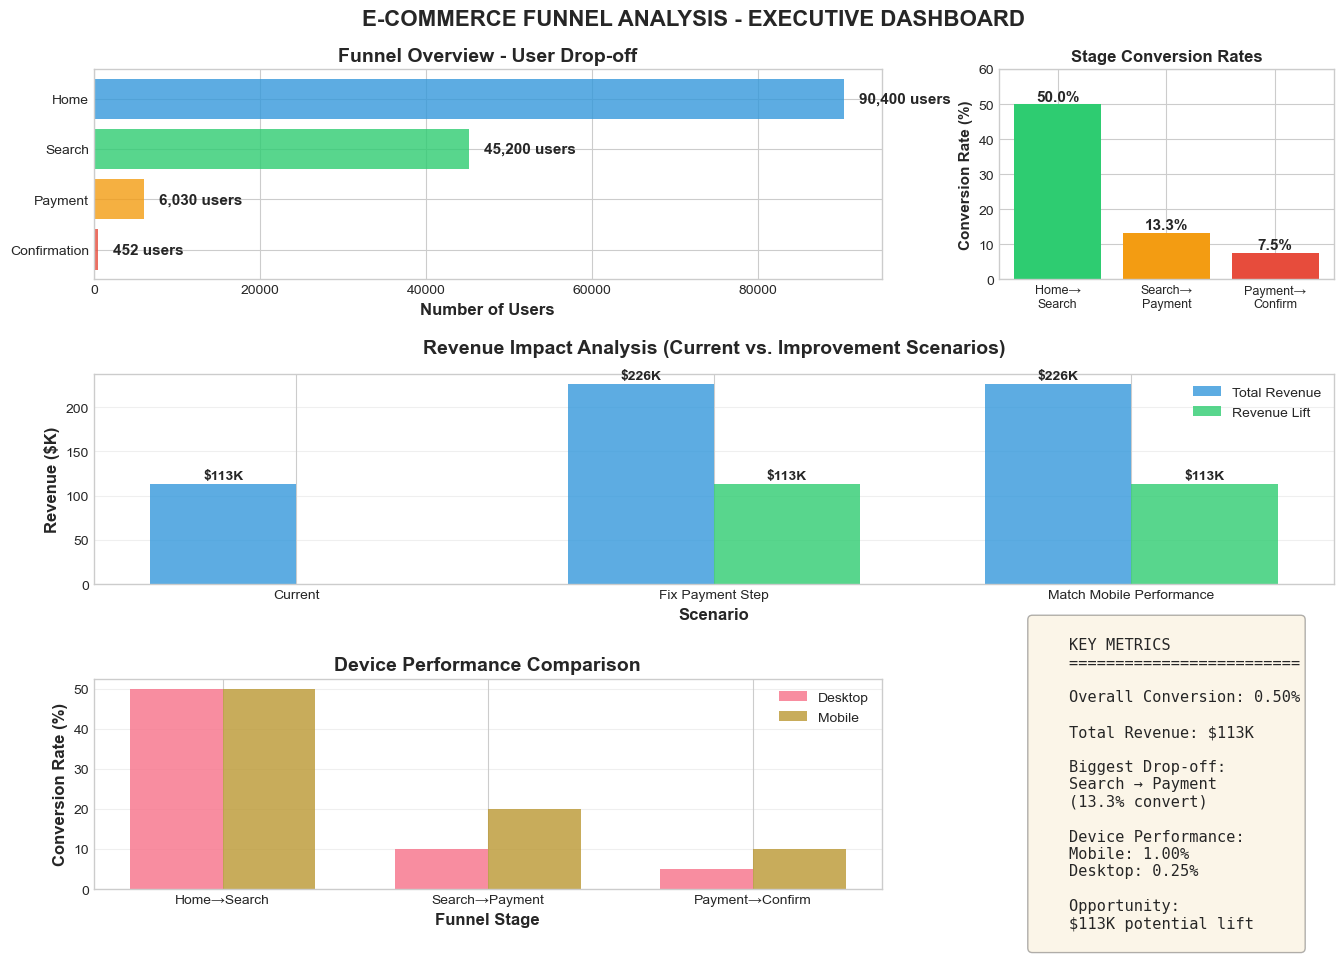

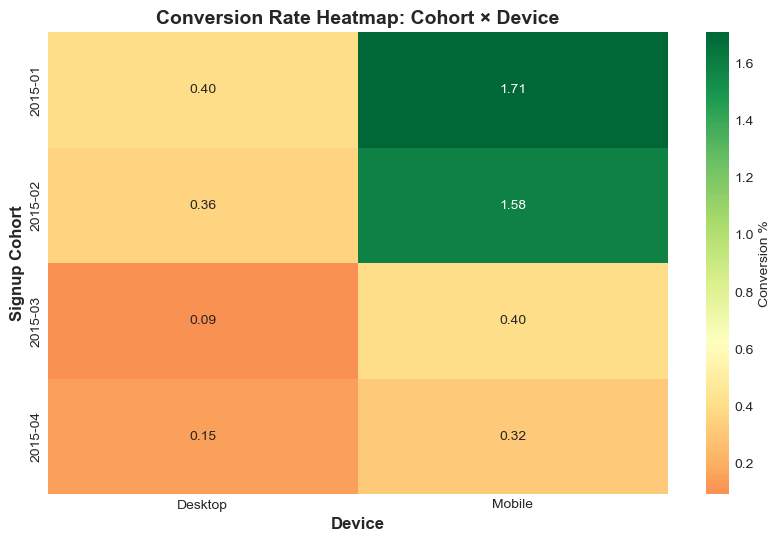

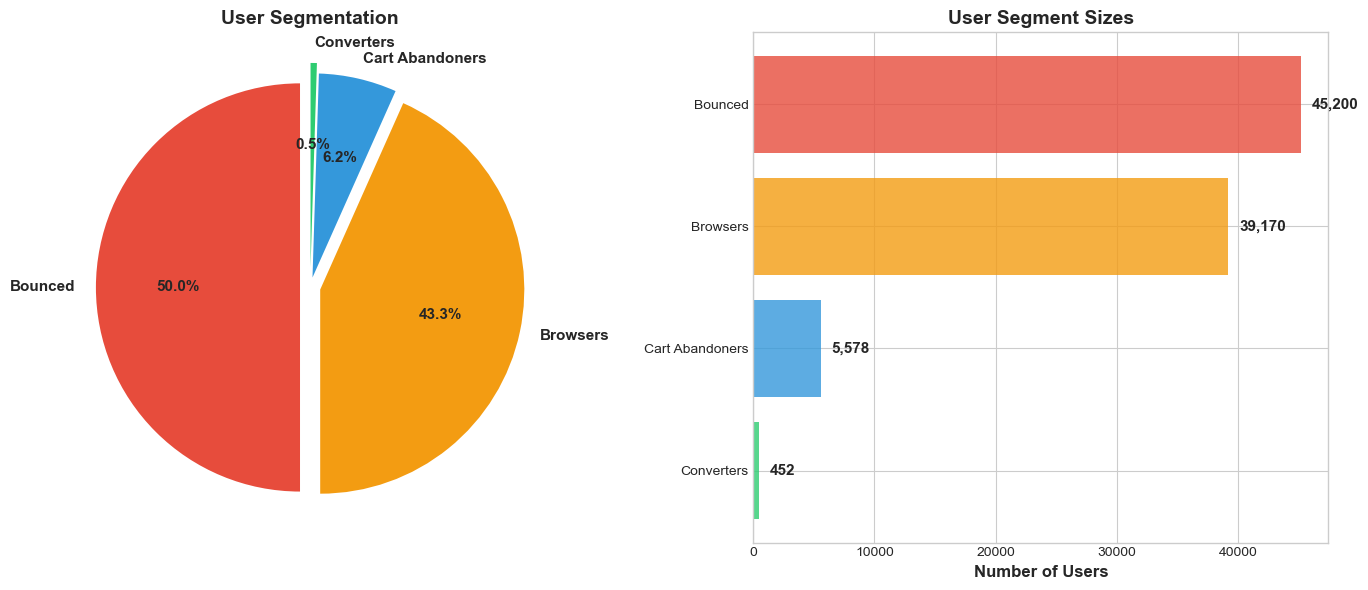

In [47]:
# Execute analysis
if __name__ == "__main__":
    df, insights, revenue_impact = main()